In [1]:
!pip install pennylane
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from sklearn.decomposition import PCA
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data, InMemoryDataset
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


In [3]:
class CustomDataset(InMemoryDataset):
    def __init__(self, data, transform=None):
        super().__init__(root='data/Cora', transform=transform)
        self.data, self.slices = self.collate([data])

    def _download(self):
        pass

    def _process(self):
        pass
    def __len__(self):
        return self.data.num_nodes

    def __getitem__(self, idx):
        # Return the features and labels for the given index
        return self.data.x[idx], self.data.y[idx]

In [4]:
# Load Cora dataset
transform = T.NormalizeFeatures()
dataset = Planetoid(root='data/Cora', name='Cora', transform=transform)
data = dataset[0]

# Select two classes for binary classification
class_0, class_1 = 2, 4
mask = (data.y == class_0) | (data.y == class_1)
subset_indices = mask.nonzero(as_tuple=True)[0]

# Create a subgraph using the subset indices
data = data.subgraph(subset_indices)

data.edge_index = data.edge_index[:, (data.edge_index[0, :] < data.num_nodes) & (data.edge_index[1, :] < data.num_nodes)]
# Map original edge indices to the new subgraph indices
mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(subset_indices.tolist())}
data.edge_index = torch.tensor([[mapping.get(i.item(), -1) for i in data.edge_index[0]],
                                 [mapping.get(i.item(), -1) for i in data.edge_index[1]]], dtype=torch.long)
# Remove edges with invalid indices (-1)
valid_edges = (data.edge_index[0] != -1) & (data.edge_index[1] != -1)
data.edge_index = data.edge_index[:, valid_edges]

data.y = (data.y == class_1).long()  # Convert to binary labels

# Apply PCA to reduce features to 256
def apply_pca(features, n_components=256):
    pca = PCA(n_components=n_components)
    return torch.tensor(pca.fit_transform(features.numpy()), dtype=torch.float)

data.x = apply_pca(data.x)

# Create train/test split
train_mask = torch.rand(data.num_nodes) < 0.8
test_mask = ~train_mask

train_indices = train_mask.nonzero(as_tuple=True)[0]
test_indices = test_mask.nonzero(as_tuple=True)[0]

# Create CustomDataset instances for train and test
train_dataset = CustomDataset(data.subgraph(train_indices))
test_dataset = CustomDataset(data.subgraph(test_indices))

# Now you can use DataLoader with these custom datasets:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)



Processing...
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [5]:
unique, counts = torch.unique(data.y, return_counts=True)
print(unique, counts)
print(dict(zip(unique.tolist(), counts.tolist())))

tensor([0, 1]) tensor([418, 426])
{0: 418, 1: 426}


In [6]:
# Normalize adjacency matrix
A = to_dense_adj(data.edge_index).squeeze(0)
A = A + torch.eye(A.shape[0])  # Add self-loops
D_inv_sqrt = torch.diag(1.0 / torch.sqrt(A.sum(dim=1)))
A_norm = D_inv_sqrt @ A @ D_inv_sqrt  # Symmetric normalization

In [7]:
def Rot_layer(gate, w):
    """
    Applies a given rotation gate (e.g., qml.RY or qml.RZ) to each qubit
    with the corresponding parameter in w.
    """
    for idx, element in enumerate(w):
        gate(element, wires=idx)

def entangling_layer(nqubits):
    """
    Applies a ring of CNOT gates to entangle all qubits.
    """
    for i in range(nqubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[nqubits - 1, 0])


In [8]:
def quantum_net(n_qubits, q_depth, feature_dim):
    """
    Variational quantum circuit used in the graph convolution layer.
    Uses amplitude encoding to embed a feature vector of length 'feature_dim'
    (which should equal 2^n_qubits) into the quantum state.
    Then applies q_depth layers of parameterized rotations and entangling gates.
    """

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):

        eps = 1e-7
        inputs = inputs + eps
        qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)


        q_weights = q_weights_flat.reshape(q_depth, 2, n_qubits)


        for k in range(q_depth):
            Rot_layer(qml.RY, q_weights[k][0])
            entangling_layer(n_qubits)
            Rot_layer(qml.RZ, q_weights[k][1])


        exp_vals = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        return exp_vals


    num_params = 2 * q_depth * n_qubits

    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": (num_params,)}), quantum_circuit


In [9]:
def givens_rotation_matrix(theta, i, j, size):
    G = torch.eye(size)
    # Convert theta to a PyTorch tensor
    theta = torch.tensor(theta, dtype=torch.float32)
    c, s = torch.cos(theta/2), torch.sin(theta/2)
    G[i, i], G[i, j] = c, s
    G[j, i], G[j, j] = -s, c
    return G

def quantum_message_passing(features, A_norm):
    batch_size = features.shape[0]  # Get the batch size
    updated_features = features.clone()

    # Iterate over nodes in the batch
    for i in range(batch_size):
        for j in range(batch_size):  # Iterate over all nodes in the graph
            if A_norm[i, j] > 0:  # Check for connection between nodes i and j
                theta = np.pi/2

                # Apply rotation to the features of nodes i and j within the batch
                # Create a 2x2 Givens rotation matrix for the 2 nodes
                G = givens_rotation_matrix(theta, 0, 1, 2)

                # Extract features for nodes i and j
                # Select only the first two features for the rotation
                node_features = torch.stack([updated_features[i][:2], updated_features[j][:2]])

                # Apply rotation and update features
                rotated_features = torch.mv(G, node_features[0])
                # Update only the first two features for node i
                updated_features[i][:2] = rotated_features
    return updated_features

In [10]:
class QuantumGCN(torch.nn.Module):
    def __init__(self, n_qubits, n_classes=2):
        super().__init__()
        self.q_feature = quantum_net(n_qubits, 1, 256)[0]
        self.fc = torch.nn.Linear(n_qubits, n_classes)

    def forward(self, x, A_norm):
        x = self.q_feature(x)
        x = quantum_message_passing(x, A_norm)
        return self.fc(x)

In [11]:
device = torch.device("cpu")
model = QuantumGCN(8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
A_norm = A_norm.to(device)

In [12]:
train_losses, test_accuracies = [], []

for epoch in range(60):
    model.train()
    total_loss = 0
    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_x, A_norm)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Evaluate on test set
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            out = model(batch_x, A_norm)
            pred = out.argmax(dim=1)
            correct += (pred == batch_y).sum().item()
    accuracy = correct / test_dataset.__len__()
    test_accuracies.append(accuracy)

    if epoch % 1 == 0:
        print(f"\nEpoch {epoch}: Loss = {train_losses[-1]:.4f}, Accuracy = {accuracy:.4f}")


100%|██████████| 21/21 [00:04<00:00,  5.10it/s]



Epoch 0: Loss = 0.6960, Accuracy = 0.4942


100%|██████████| 21/21 [00:02<00:00,  7.47it/s]



Epoch 1: Loss = 0.6936, Accuracy = 0.4826


100%|██████████| 21/21 [00:04<00:00,  4.37it/s]



Epoch 2: Loss = 0.6890, Accuracy = 0.4767


100%|██████████| 21/21 [00:02<00:00,  8.16it/s]



Epoch 3: Loss = 0.6862, Accuracy = 0.4884


100%|██████████| 21/21 [00:01<00:00, 15.63it/s]



Epoch 4: Loss = 0.6823, Accuracy = 0.5349


100%|██████████| 21/21 [00:01<00:00, 16.02it/s]



Epoch 5: Loss = 0.6777, Accuracy = 0.5523


100%|██████████| 21/21 [00:01<00:00, 16.07it/s]



Epoch 6: Loss = 0.6708, Accuracy = 0.5698


100%|██████████| 21/21 [00:01<00:00, 15.97it/s]



Epoch 7: Loss = 0.6566, Accuracy = 0.6221


100%|██████████| 21/21 [00:01<00:00, 12.07it/s]



Epoch 8: Loss = 0.6415, Accuracy = 0.6686


100%|██████████| 21/21 [00:01<00:00, 13.35it/s]



Epoch 9: Loss = 0.6253, Accuracy = 0.6860


100%|██████████| 21/21 [00:01<00:00, 15.27it/s]



Epoch 10: Loss = 0.6117, Accuracy = 0.7151


100%|██████████| 21/21 [00:01<00:00, 15.14it/s]



Epoch 11: Loss = 0.6040, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 16.01it/s]



Epoch 12: Loss = 0.6002, Accuracy = 0.7384


100%|██████████| 21/21 [00:01<00:00, 15.29it/s]



Epoch 13: Loss = 0.5972, Accuracy = 0.7384


100%|██████████| 21/21 [00:01<00:00, 13.63it/s]



Epoch 14: Loss = 0.5921, Accuracy = 0.7442


100%|██████████| 21/21 [00:01<00:00, 13.32it/s]



Epoch 15: Loss = 0.5924, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 11.62it/s]



Epoch 16: Loss = 0.5888, Accuracy = 0.7384


100%|██████████| 21/21 [00:01<00:00, 15.93it/s]



Epoch 17: Loss = 0.5877, Accuracy = 0.7442


100%|██████████| 21/21 [00:01<00:00, 15.89it/s]



Epoch 18: Loss = 0.5905, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 16.21it/s]



Epoch 19: Loss = 0.5854, Accuracy = 0.7384


100%|██████████| 21/21 [00:01<00:00, 16.01it/s]



Epoch 20: Loss = 0.5852, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 16.18it/s]



Epoch 21: Loss = 0.5870, Accuracy = 0.7209


100%|██████████| 21/21 [00:01<00:00, 15.93it/s]



Epoch 22: Loss = 0.5840, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 11.88it/s]



Epoch 23: Loss = 0.5830, Accuracy = 0.7384


100%|██████████| 21/21 [00:01<00:00, 13.74it/s]



Epoch 24: Loss = 0.5868, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 15.91it/s]



Epoch 25: Loss = 0.5794, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 16.21it/s]



Epoch 26: Loss = 0.5861, Accuracy = 0.7384


100%|██████████| 21/21 [00:01<00:00, 16.07it/s]



Epoch 27: Loss = 0.5836, Accuracy = 0.7209


100%|██████████| 21/21 [00:01<00:00, 15.91it/s]



Epoch 28: Loss = 0.5855, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 15.61it/s]



Epoch 29: Loss = 0.5817, Accuracy = 0.7209


100%|██████████| 21/21 [00:01<00:00, 15.65it/s]



Epoch 30: Loss = 0.5822, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 11.13it/s]



Epoch 31: Loss = 0.5836, Accuracy = 0.7209


100%|██████████| 21/21 [00:01<00:00, 15.66it/s]



Epoch 32: Loss = 0.5853, Accuracy = 0.7209


100%|██████████| 21/21 [00:01<00:00, 16.07it/s]



Epoch 33: Loss = 0.5800, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 15.73it/s]



Epoch 34: Loss = 0.5839, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 16.06it/s]



Epoch 35: Loss = 0.5846, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 16.25it/s]



Epoch 36: Loss = 0.5823, Accuracy = 0.7209


100%|██████████| 21/21 [00:01<00:00, 16.29it/s]



Epoch 37: Loss = 0.5826, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 12.90it/s]



Epoch 38: Loss = 0.5821, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 12.47it/s]



Epoch 39: Loss = 0.5826, Accuracy = 0.7209


100%|██████████| 21/21 [00:01<00:00, 16.35it/s]



Epoch 40: Loss = 0.5804, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 16.04it/s]



Epoch 41: Loss = 0.5778, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 16.34it/s]



Epoch 42: Loss = 0.5816, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 16.37it/s]



Epoch 43: Loss = 0.5840, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 16.49it/s]



Epoch 44: Loss = 0.5834, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 16.25it/s]



Epoch 45: Loss = 0.5786, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 11.55it/s]



Epoch 46: Loss = 0.5853, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 14.21it/s]



Epoch 47: Loss = 0.5817, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 16.03it/s]



Epoch 48: Loss = 0.5810, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 16.40it/s]



Epoch 49: Loss = 0.5842, Accuracy = 0.7209


100%|██████████| 21/21 [00:01<00:00, 15.69it/s]



Epoch 50: Loss = 0.5919, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 15.82it/s]



Epoch 51: Loss = 0.5799, Accuracy = 0.7209


100%|██████████| 21/21 [00:01<00:00, 15.80it/s]



Epoch 52: Loss = 0.5843, Accuracy = 0.7209


100%|██████████| 21/21 [00:03<00:00,  6.16it/s]



Epoch 53: Loss = 0.5832, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 13.80it/s]



Epoch 54: Loss = 0.5792, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 15.82it/s]



Epoch 55: Loss = 0.5809, Accuracy = 0.7326


100%|██████████| 21/21 [00:01<00:00, 15.61it/s]



Epoch 56: Loss = 0.5783, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 15.64it/s]



Epoch 57: Loss = 0.5832, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 15.43it/s]



Epoch 58: Loss = 0.5846, Accuracy = 0.7267


100%|██████████| 21/21 [00:01<00:00, 16.22it/s]



Epoch 59: Loss = 0.5779, Accuracy = 0.7267


In [15]:
def plot_loss_accuracy(train_losses, test_accuracies):
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

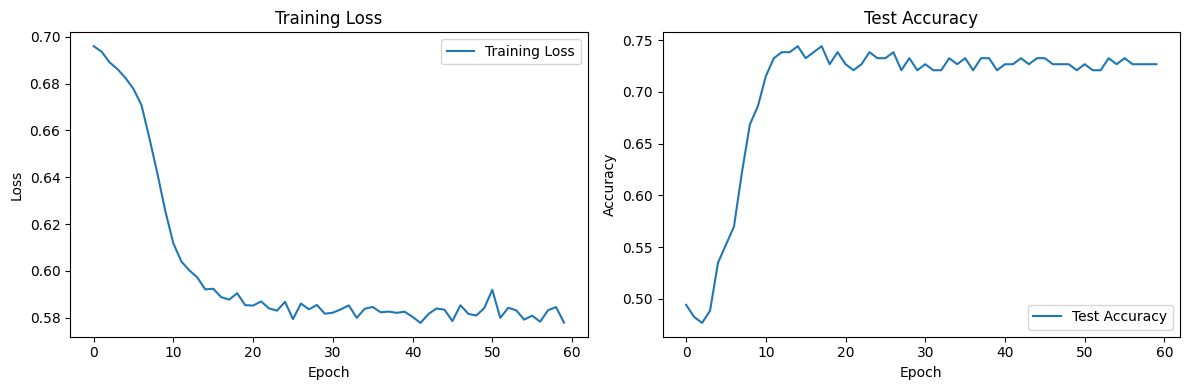

In [16]:
plot_loss_accuracy(train_losses, test_accuracies)